In [27]:
from google.colab import files
src = list(files.upload().values())[0]
open('vb100_utils.py','wb').write(src)
import vb100_utils

Saving vb100_utils.py to vb100_utils (2).py


In [2]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow

Found existing installation: keras-nightly 2.5.0.dev2021032900
Uninstalling keras-nightly-2.5.0.dev2021032900:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras/*
    /usr/local/lib/python3.7/dist-packages/keras_nightly-2.5.0.dev2021032900.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/keras/applications/mobilenetv2.py
    /usr/local/lib/python3.7/dist-packages/keras/applications/resnet50.py
    /usr/local/lib/python3.7/dist-packages/keras/backend/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/backend/cntk_backend.py
    /usr/local/lib/python3.7/dist-packages/keras/backend/common.py
    /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py
    /usr/local/lib/python3.7/dist-packages/keras/backend/theano_backend.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/network.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/topology.py
    /usr/local/lib/python3.7/dist-pack

In [1]:
#! pip install tensorflow==2.1.0
!pip install tensorflow==1.13.1
! pip install keras==2.2.4

In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from vb100_utils import *

#from vb100_utils import *
from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
!pip install sklearn
!pip install -U matplotlib
!pip install Pillow

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir = '/content/drive/MyDrive/Data/'
!ls -lh $data_dir

total 39K
drwx------ 2 root root 4.0K Jul 16 18:22 __pycache__
drwx------ 5 root root 4.0K Jun 13 10:29 train
-rw------- 1 root root 7.8K Nov 25  2018 train-abnormal.csv
-rw------- 1 root root 7.8K Nov 25  2018 train-acl.csv
-rw------- 1 root root 7.8K Nov 25  2018 train-meniscus.csv
drwx------ 5 root root 4.0K Jun 13 10:29 valid
-rw------- 1 root root  840 Nov 25  2018 valid-abnormal.csv
-rw------- 1 root root  840 Nov 25  2018 valid-acl.csv
-rw------- 1 root root  840 Nov 25  2018 valid-meniscus.csv


In [6]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 1.13.1
Keras version = 2.2.4


In [7]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = '/content/drive/MyDrive/Data/train'
VALID_DIR = '/content/drive/MyDrive/Data/valid'
#TEST_DIR = '/content/drive/MyDrive/Data/test'
#TEST_DIR = '/content/drive/MyDrive/Data/train'
l_DIRS = [TRAIN_DIR, VALID_DIR]
POSITIVE_CLASS = 'ABNORMAL'
ABSTRACT_CLASS = 'ACL'

# CONSTANTS FOR IMAGE PARAMETERS
INPUT_W = 1200 # pixels
INPUT_H = 900  # pixels
DIVIDER = 3.6
INPUT_DIM = (int(INPUT_W/DIVIDER), int(INPUT_H/DIVIDER), 1)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64 
BATCH_SIZE_VALID = 16
NORMALIZER = 1./255
#IMAGE_FORMAT = '.npy'
IMAGE_FORMAT = 'jpg'

# Output Info
print('Image dimmensions for CNN = {}'.format(INPUT_DIM))

Image dimmensions for CNN = (333, 250, 1)


In [8]:
if abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
   structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(l_DIRS)

print('Catched classes for the model:\n{}'.format(classes))

Data are valid and ready to be feeded to the model already.

Catched classes for the model:
{'TRAIN': ['coronal', 'axial', 'sagittal'], 'VALIDATION': ['sagittal', 'axial', 'coronal']}


Found 182 images belonging to 3 classes.


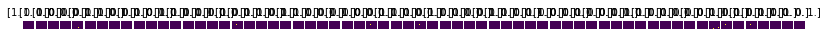

In [9]:
# Generating and Plot Image Data from Train Set
TRAIN_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TRAIN_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TRAIN'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TRAIN)

imgs, labels = next(TRAIN_BATCHES)  # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)          # <-- Plot Images with labels
#train_imgs = rgb_to_grayscale(imgs) # <-- Convert RGB images to Grayscale ones by Tensorflow
#train_labels = labels

Found 210 images belonging to 3 classes.


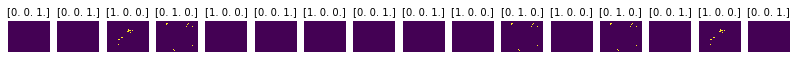

In [10]:
# Generating and Plot Image Data from Validation Set
VAL_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(VALID_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['VALIDATION'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_VALID)

imgs, labels = next(VAL_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)         # <-- Plot Images with labels
#val_imgs = rgb_to_grayscale(imgs)  # < -- Convert RGB images to Grayscale ones by Tensorflow
#val_labels = labels

In [11]:
# Output of Generators
for data_batch, label_batch in TRAIN_BATCHES:
    print('data batch shape = {}'.format(data_batch.shape))
    print('labels batch shape = {}'.format(label_batch.shape))
    break

data batch shape = (64, 333, 250, 1)
labels batch shape = (64, 3)


In [13]:
# Build the CNN model
#tf.compat.v1.reset_default_graph()

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import backend as k
#from tensorflow.python.keras import backend as k
#from tensorflow.python.framework import ops
#ops.get_default_graph()


model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(INPUT_DIM)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (4, 4))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.02))) 
model.add(Activation('relu'))

model.add(Dense(3)) 
model.add(Activation('softmax'))

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 329, 246, 64)      1664      
_________________________________________________________________
activation_9 (Activation)    (None, 329, 246, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 109, 82, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 79, 128)      131200    
_________________________________________________________________
activation_10 (Activation)   (None, 106, 79, 128)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 39, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 37, 512)       590336    
__________

In [66]:
# Define an optimizer for the model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999,epsilon=None, decay=0.0, amsgrad=False)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.85, nesterov=True)
#opt = RMSprop(lr=0.001, rho=0.8, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
optimizer=opt)

ValueError: ignored

In [16]:
print('steps_per_epoch={}'.format(int(182 / BATCH_SIZE_TRAIN)))
print('validation_steps={}'.format(int(170 / BATCH_SIZE_TEST)))

#print('steps_per_epoch={}'.format(int(4 / 2)))
#print('validation_steps={}'.format(int(6 / 6)))

steps_per_epoch=2
validation_steps=2


In [18]:
%%time
model.fit_generator(
    TRAIN_BATCHES,
    steps_per_epoch=len(TRAIN_BATCHES),
    validation_data=VAL_BATCHES,
    validation_steps=len(VAL_BATCHES),
    epochs=2,
    verbose=2
)

# Parameters meanings:
# steps_per_epoch = number_of_images / batch_size = 5215 / 64 = 82:
# --- Total number of steps (batches of samples) to yield from generator before declaring one 
#     epoch finished and starting the next epoch. It should typically be equal to the number 
#     of unique samples of your dataset divided by the batch size.
# Verbose:
# -- 0 (quiet): you just get the total numbers of tests executed and the global result
# -- 1 (default): you get the same plus a dot for every successful test or a F for every failure
# -- 2 (verbose): you get the help string of every test and the result

Epoch 1/2
 - 182s - loss: 11.2878 - acc: 0.3759 - val_loss: 11.2885 - val_acc: 0.3190
Epoch 2/2
 - 176s - loss: 11.2707 - acc: 0.3766 - val_loss: 11.2758 - val_acc: 0.3429
CPU times: user 11min 28s, sys: 8.52 s, total: 11min 37s
Wall time: 5min 57s


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('vb100_utils.py','wb').write(src)
import vb100_utils

Saving vb100_utils.py to vb100_utils (3).py


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


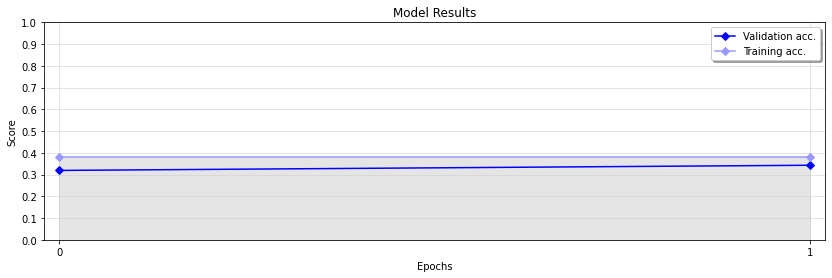

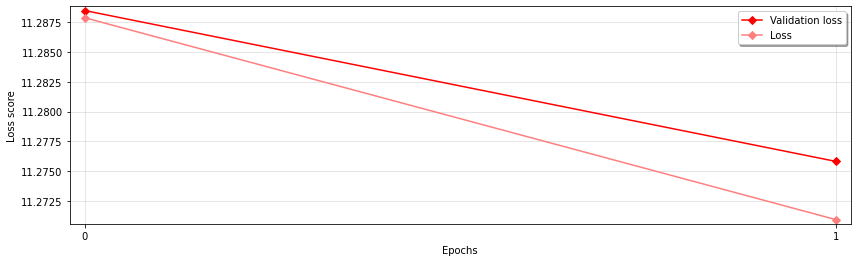

In [19]:
plot_model_result(model)

In [20]:
# Save the results as separate lists
df = save_model_result(model)

    val_acc       acc   val_loss       loss
0  0.319048  0.379121  11.288496  11.287891
1  0.342857  0.379121  11.275805  11.270908


Result data is saved as file: model_results_2021-07-29_09-08.csv


In [21]:
# Save the Model Weights
model.save_weights('/content/drive/MyDrive/model_keras.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('/content/drive/MyDrive/model1.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [22]:
# ------------------------------------------------------------------------
# Load saved model and its weights
'''
>> Model weights are saved to HDF5 format.
>> The model structure can be described and saved using two different formats: JSON and YAML.
'''

# Import dependencies
from keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()
import h5py 
from PIL import Image
import PIL
from vb100_utils import *

In [23]:
print('h5py version is {}'.format(h5py.__version__))

h5py version is 2.10.0


In [24]:
# Get the architecture of CNN
json_file = open('/content/drive/MyDrive/model1.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Get weights into the model
loaded_model.load_weights('/content/drive/MyDrive/model_100_eopchs_adam_20191030_01.h5')

In [52]:
classes = {'TRAIN': ['axial', 'coronal', 'sagittal'],
           'VALIDATION': ['axial', 'coronal', 'sagittal']}
IMG = Image.open('/content/drive/MyDrive/coronal2.jpg')
print(type(IMG))
print(IMG.size)
IMG = IMG.resize((333, 250))
#IMG = IMG.resize((342, 257))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(64, 333, 250, 1)
#IMG = IMG.reshape(-1, 1, 342, 257)
#data.reshape((-1, 1, 28, 28))

#IMG = IMG.reshape(1, 200, 255, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = loaded_model.predict_classes(IMG)
print(predictions, predictions_c)
predicted_class = classes['TRAIN'][predictions_c[0]]
print('We think that is {}.'.format(predicted_class.lower()))


<class 'PIL.JpegImagePlugin.JpegImageFile'>
(200, 200)
po array = (250, 333, 3)


ValueError: ignored

In [25]:
'''
Here I will simulate what will happen during deployment on a cloud.
Reading a given image, preparing it for CNN evaluation and make
a predictions with a returned class from a dictionary that has
been used for training.
'''

# Define optimizer and run
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')


'''
Important Note! For this block optimizer is entered manualy as Tensorflow object.
For future, need to change it for include it as variable with full set of
parameters as Tensorflow variable.

'''
#TRAIN_DIR = '/content/drive/MyDrive/Data/train'
#VALID_DIR = '/content/drive/MyDrive/Data/valid'
IMG = Image.open('/content/drive/MyDrive/coronal2.jpg')
print(type(IMG))
print(IMG.size)
IMG = IMG.resize((342, 257))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(64, 333, 250, 1)
#IMG = IMG.reshape(1, 200, 255, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = loaded_model.predict_classes(IMG)
print(predictions, predictions_c)


ValueError: ignored